In [14]:
import hdbscan
import numpy as np
from sklearn.datasets import make_blobs

# 1. サンプルデータの準備
data, _ = make_blobs(n_samples=500, centers=5, cluster_std=0.8, random_state=42)
N = data.shape[0]
print(f"Number of data points: {N}")

# 2. HDBSCANの実行
hdbscan_instance = hdbscan.HDBSCAN(min_cluster_size=10, core_dist_n_jobs=-1, gen_min_span_tree=True).fit(data)

# Single Linkage Treeのデータ (すべての結合情報)
linkage_data = hdbscan_instance.single_linkage_tree_.to_numpy()
print(f"length of linkage_data: {len(linkage_data)}")
print(f"first row of linkage_data: {linkage_data[0]}")  # 最初の行を表示

def find_nearest_original_points(linkage_data, N, cluster_index_A, cluster_index_B):
    """
    Single Linkage Treeのデータから、指定された2つの要素 (点またはクラスタ) の結合イベントにおいて、
    結合を直接引き起こした2つの原始データ点 (p_A, p_B) を特定する関数。
    
    Args:
        linkage_data (np.ndarray): hdbscan_instance.single_linkage_tree_.to_numpy()の結果。
        N (int): データ点の総数。
        cluster_index_A (int): 結合した要素Aのインデックス (0 <= index < N ならデータ点、N <= index ならクラスタ)。
        cluster_index_B (int): 結合した要素Bのインデックス。
        
    Returns:
        tuple: (点Aのインデックス, 点Bのインデックス, 結合距離)。見つからなかった場合は None。
    """
    
    # クラスタインデックス (N以上) がどの行 (結合イベント) で生成されたかをマップ
    # {クラスタインデックス: linkage_dataの行インデックス}
    cluster_to_row = {int(N + i): i for i in range(len(linkage_data))}

    def get_leaf_nodes(index):
        """指定されたインデックスが含む全ての原始データ点のリストを再帰的に取得する"""
        if index < N:
            # 原始データ点の場合、それ自身を返す
            return {int(index)}
        elif index in cluster_to_row:
            # クラスタの場合、そのクラスタを形成した結合イベントの情報を取得し、再帰的に辿る
            row_index = cluster_to_row[index]
            c1_idx, c2_idx, _, _ = linkage_data[row_index]
            
            # c1_idxとc2_idxに含まれる葉ノード (データ点) を取得
            leaves = get_leaf_nodes(c1_idx)
            leaves.update(get_leaf_nodes(c2_idx))
            return leaves
        else:
            # 不正なインデックス
            return set()

    # 1. 結合イベントを見つける (簡略化のため、ここでは直接的な結合を想定)
    #    実際は Condensed Treeのインデックスを Single Linkage Treeの対応する部分で見つける必要があるが、
    #    ここでは簡略化し、Single Linkage Treeの中から C_A と C_B が結合した最初のイベントを探す
    
    # Single Linkage Treeで C_A と C_B が結合した行を探す
    
    # C_A と C_B が結合した行のインデックスを取得
    # 注意: Single Linkage Treeでは C_A と C_B は N 以上のクラスタインデックスとして現れる
    # N以上のインデックスは linkage_data の行インデックス + N
    
    # 簡略化されたロジック: Single Linkage Treeから、C_A と C_B の構成員が初めて結合する行を見つける
    
    # AとBに含まれる全データ点のセットを取得
    set_A = get_leaf_nodes(cluster_index_A)
    set_B = get_leaf_nodes(cluster_index_B)

    # 3. MST/距離情報から、set_Aとset_Bの間で最も相互到達性距離が小さい点を見つける
    #    HDBSCANは内部的に距離行列を持っていないため、Single Linkage Treeの情報を利用するのが最も効率的。
    
    # Single Linkage Treeを距離の小さい順に走査し、
    # 結合した2つの要素がそれぞれ A と B の構成員を初めて結びつける行を探す。
    
    for row in linkage_data:
        c1_idx, c2_idx, distance, _ = row
        
        # c1_idx と c2_idx の原始データ点セットを取得
        leaves_c1 = get_leaf_nodes(c1_idx)
        leaves_c2 = get_leaf_nodes(c2_idx)
        
        # c1 と c2 が、セット A と セット B を結びつけるエッジになっているかを確認
        # (c1の構成員がAにのみ含まれ、c2の構成員がBにのみ含まれる、またはその逆)
        
        # c1 の点が A にのみ含まれ、c2 の点が B にのみ含まれるケース
        condition_A_to_B = (leaves_c1.issubset(set_A) and leaves_c2.issubset(set_B) and 
                            len(leaves_c1) > 0 and len(leaves_c2) > 0)
        
        # c1 の点が B にのみ含まれ、c2 の点が A にのみ含まれるケース
        condition_B_to_A = (leaves_c1.issubset(set_B) and leaves_c2.issubset(set_A) and
                            len(leaves_c1) > 0 and len(leaves_c2) > 0)
        
        if condition_A_to_B or condition_B_to_A:
            # この行が A と B の最初の結合イベントであると仮定できる
            
            # 結合の原因となった原始データ点を見つける
            # 結合を決定づけたのは、c1に含まれる点とc2に含まれる点の間の最小相互到達性距離。
            
            # Single Linkage Treeの定義上、c1とc2の結合エッジが、
            # c1とc2に含まれる全点間の相互到達性距離の最小値であるため、
            # c1内の任意の点 p_A と c2内の任意の点 p_B を取っても、それがその距離の結合原因とは限らない。
            # しかし、Single Linkage Treeの構造が、結合を**引き起こした最も密な繋がり**を表現しているため、
            # ここでは c1 の**最も新しい構成点**と c2 の**最も新しい構成点**を原因点とするのが最も合理的。
            
            # 最もシンプルなロジック: c1, c2 を構成する葉ノードからランダムに1点ずつ選ぶ
            # 厳密な特定は、MSTの全エッジデータが必要です。ここでは簡略化のため、c1, c2 の代表点として
            # c1, c2 の葉ノードの中から、それぞれのインデックスの最も若い点（最初に生成された点）を原因点とする。
            
            # 原因点の候補を、それぞれの要素に含まれる葉ノードのリストから取得
            point_A_candidates = list(leaves_c1) if condition_A_to_B else list(leaves_c2)
            point_B_candidates = list(leaves_c2) if condition_A_to_B else list(leaves_c1)
            
            # 便宜上、それぞれのセットの最小インデックスを原因点として選択
            p_A_index = min(point_A_candidates)
            p_B_index = min(point_B_candidates)
            
            return int(p_A_index), int(p_B_index), distance

    return None, None, None

# --- 実行例 ---

# 注: Condensed Treeのノードインデックス (N以上) は Single Linkage Treeの対応するインデックスと異なります。
# 以下の例では、結合をトレースするために、Single Linkage Treeのインデックスを直接使用します。
# 実際のユースケースでは、Condensed Treeのノードに対応する Single Linkage Tree の部分を特定する
# 複雑な前処理が必要になります。

# 簡略化のため、Single Linkage Treeの適当な大きなクラスタ結合を選んでトレースします。
# 例えば、下から数えて3番目に大きい結合 (大きなクラスタ結合の候補) を選択します。

# linkage_data は通常、距離の昇順でソートされている
target_row_index = len(linkage_data) - 2
target_row = linkage_data[target_row_index]

# 結合した2つの要素のインデックスと結合距離
C_A_idx, C_B_idx, distance, _ = target_row
C_A_idx, C_B_idx = int(C_A_idx), int(C_B_idx)

print(f"--- 結合イベントのトレース ---")
print(f"ターゲット結合イベント (Single Linkage Treeの行 {target_row_index}):")
print(f"要素 A (インデックス {C_A_idx}) と 要素 B (インデックス {C_B_idx}) が距離 {distance:.4f} で結合")

# 関数を実行して原因点を特定
p_A, p_B, final_distance = find_nearest_original_points(linkage_data, N, C_A_idx, C_B_idx)

if p_A is not None:
    print("\n--- 結合の直接的原因となった原始データ点 ---")
    print(f"原因点 p_A (インデックス {p_A}): {data[p_A]}")
    print(f"原因点 p_B (インデックス {p_B}): {data[p_B]}")
    print(f"結合を決定づけた距離: {final_distance:.4f} (これは p_A と p_B の間の距離ではありません)")
else:
    print("\n原因となった原始データ点を特定できませんでした。")

Number of data points: 500
length of linkage_data: 499
first row of linkage_data: [1.10000000e+01 3.15000000e+02 2.62488291e-01 2.00000000e+00]
--- 結合イベントのトレース ---
ターゲット結合イベント (Single Linkage Treeの行 497):
要素 A (インデックス 991) と 要素 B (インデックス 996) が距離 4.4108 で結合

--- 結合の直接的原因となった原始データ点 ---
原因点 p_A (インデックス 14): [-8.86631855  8.74016342]
原因点 p_B (インデックス 0): [4.63008142 1.25536619]
結合を決定づけた距離: 4.4108 (これは p_A と p_B の間の距離ではありません)


In [17]:
import hdbscan
import numpy as np
from sklearn.datasets import make_blobs

# サンプルデータの準備
data, _ = make_blobs(n_samples=500, centers=5, cluster_std=0.8, random_state=42)
N = data.shape[0]

# gen_min_span_tree=True を設定してHDBSCANを実行
hdbscan_instance = hdbscan.HDBSCAN(
    min_cluster_size=10, 
    gen_min_span_tree=True,  # ★ ここでMSTの生成を有効にする
    core_dist_n_jobs=-1
).fit(data)

# Single Linkage Treeのデータ（結合情報）
linkage_data = hdbscan_instance.single_linkage_tree_.to_numpy()

# MSTのデータ
# 構成: [ノード1のインデックス, ノード2のインデックス, 相互到達性距離]
mst_data = hdbscan_instance.minimum_spanning_tree_.to_numpy()

In [19]:
def find_causal_points_with_mst(hdbscan_instance, N, cluster_index_A, cluster_index_B):
    """
    MSTとSingle Linkage Treeを使用して、クラスタ結合の原因となったデータ点を特定する。
    
    Args:
        hdbscan_instance: 実行済みの HDBSCAN インスタンス。
        N (int): データ点の総数。
        cluster_index_A (int): 結合した要素Aのインデックス。
        cluster_index_B (int): 結合した要素Bのインデックス。
        
    Returns:
        tuple: (原因点Aのインデックス, 原因点Bのインデックス, 結合距離)。
    """
    linkage_data = hdbscan_instance.single_linkage_tree_.to_numpy()
    mst_data = hdbscan_instance.minimum_spanning_tree_.to_numpy()
    
    # 1. get_leaf_nodes 関数を再定義 (前回の回答のものを使用)
    cluster_to_row = {int(N + i): i for i in range(len(linkage_data))}
    def get_leaf_nodes(index):
        if index < N:
            return {int(index)}
        elif index in cluster_to_row:
            row_index = cluster_to_row[index]
            c1_idx, c2_idx, _, _ = linkage_data[row_index]
            leaves = get_leaf_nodes(c1_idx)
            leaves.update(get_leaf_nodes(c2_idx))
            return leaves
        return set()

    # 2. 結合対象の構成員セットを取得
    set_A = get_leaf_nodes(cluster_index_A)
    set_B = get_leaf_nodes(cluster_index_B)

    # 3. Single Linkage Treeを走査し、AとBを初めて結びつける結合イベントを特定
    target_distance = None
    for row in linkage_data:
        c1_idx, c2_idx, distance, _ = row
        leaves_c1 = get_leaf_nodes(c1_idx)
        leaves_c2 = get_leaf_nodes(c2_idx)

        # c1の構成員がAにのみ、c2の構成員がBにのみ含まれる結合を検索
        condition_A_to_B = (leaves_c1.issubset(set_A) and leaves_c2.issubset(set_B) and len(leaves_c1) > 0 and len(leaves_c2) > 0)
        condition_B_to_A = (leaves_c1.issubset(set_B) and leaves_c2.issubset(set_A) and len(leaves_c1) > 0 and len(leaves_c2) > 0)
        
        if condition_A_to_B or condition_B_to_A:
            target_distance = distance
            break # 最初の結合イベントを見つけたら終了

    if target_distance is None:
        return None, None, None

    # 4. MSTのデータから、target_distanceを持つエッジ（または最も近い重みを持つエッジ）を探す
    
    # MSTのデータは [ノード1, ノード2, 相互到達性距離] の形式
    min_dist_edge = None
    min_dist = float('inf')

    # すべてのMSTエッジをチェック
    for n1, n2, dist in mst_data:
        # このエッジが set_A と set_B の間にあるか確認
        n1_in_A = n1 in set_A
        n1_in_B = n1 in set_B
        n2_in_A = n2 in set_A
        n2_in_B = n2 in set_B
        
        # エッジが A と B を結んでいる (n1がA, n2がB, またはその逆)
        if (n1_in_A and n2_in_B) or (n1_in_B and n2_in_A):
            # 結合距離に最も近いエッジを見つける
            # Single Linkage Treeの distance は MSTエッジの重みと一致するはず
            if abs(dist - target_distance) < 1e-6: # 浮動小数点の比較
                # 最も近いエッジがこの結合の原因
                p_A = int(n1) if n1_in_A else int(n2)
                p_B = int(n2) if n2_in_A else int(n1)
                return p_A, p_B, target_distance

    return None, None, target_distance # 見つからなかった場合（通常ありえない）


# --- 実行例 ---

# Single Linkage Treeの終盤にある大きな結合イベント（例: 最後の結合から3番目）をターゲットにする
target_row_index = len(linkage_data) - 2
target_row = linkage_data[target_row_index]

C_A_idx, C_B_idx, distance, _ = target_row
C_A_idx, C_B_idx = int(C_A_idx), int(C_B_idx)

print(f"--- MSTを利用した結合原因点の特定 ---")
print(f"ターゲット結合イベント (SLTの行 {target_row_index}):")
print(f"要素 A ({C_A_idx}) と 要素 B ({C_B_idx}) が距離 {distance:.4f} で結合")

p_A, p_B, final_distance = find_causal_points_with_mst(hdbscan_instance, N, C_A_idx, C_B_idx)

if p_A is not None:
    print("\n✅ 結合の直接的原因となった原始データ点 (MSTで特定) ")
    print(f"原因点 p_A (インデックス {p_A}): {data[p_A]}")
    print(f"原因点 p_B (インデックス {p_B}): {data[p_B]}")
    print(f"結合を決定づけた相互到達性距離: {final_distance:.4f}")
else:
    print("\n原因となった原始データ点を特定できませんでした。")

--- MSTを利用した結合原因点の特定 ---
ターゲット結合イベント (SLTの行 497):
要素 A (991) と 要素 B (996) が距離 4.4108 で結合

✅ 結合の直接的原因となった原始データ点 (MSTで特定) 
原因点 p_A (インデックス 375): [-7.9189091   6.76098178]
原因点 p_B (インデックス 375): [-7.9189091   6.76098178]
結合を決定づけた相互到達性距離: 4.4108


In [35]:
mst = hdbscan_instance.minimum_spanning_tree_.to_numpy()
# distが4.4108のエッジを探す
for n1, n2, dist in mst:
    if abs(dist - 4.4108) < 1e-4:
        print(f"Found edge with dist ~4.4108: nodes {n1}, {n2}, dist {dist}")

Found edge with dist ~4.4108: nodes 375.0, 181.0, dist 4.4107760410000285


# condensed tree -> MST

In [ ]:
condensed_tree = hdbscan_instance.condensed_tree_._raw_tree
filtered_tree = condensed_tree[condensed_tree['child_size'] > 1]
print(filtered_tree)
# 結合距離で検索する
pairs = []
for row in filtered_tree:
    print(f"Searching for lambda_val: {row['lambda_val']}")
    for n1, n2, dist in mst:
        if abs(dist - 1 / row['lambda_val']) < 1e-4:
            print(f"Found edge matching condensed tree lambda_val {row['lambda_val']}: nodes {n1}, {n2}, dist {dist}")
            pairs.append((n1, n2, dist))

[(500, 501, 0.10384715, 100) (500, 502, 0.10384715, 400)
 (502, 503, 0.22671747, 100) (502, 504, 0.22671747, 300)
 (504, 505, 0.28356786, 100) (504, 506, 0.28356786, 200)
 (506, 507, 0.53068705, 103) (506, 508, 0.53068705,  96)
 (508, 509, 2.55708802,  14) (508, 510, 2.55708802,  17)]
Searching for lambda_val: 0.10384715350256139
Found edge matching condensed tree lambda_val 0.10384715350256139: nodes 108.0, 3.0, dist 9.629536932616405
Searching for lambda_val: 0.10384715350256139
Found edge matching condensed tree lambda_val 0.10384715350256139: nodes 108.0, 3.0, dist 9.629536932616405
Searching for lambda_val: 0.22671747345695567
Found edge matching condensed tree lambda_val 0.22671747345695567: nodes 375.0, 181.0, dist 4.4107760410000285
Searching for lambda_val: 0.22671747345695567
Found edge matching condensed tree lambda_val 0.22671747345695567: nodes 375.0, 181.0, dist 4.4107760410000285
Searching for lambda_val: 0.28356786096612263
Found edge matching condensed tree lambda_val 

# plot

In [16]:
# tsne
from sklearn.manifold import TSNE
import plotly.express as px
import plotly.graph_objects as go
reducer = TSNE(n_components=2, random_state=42)
embedding = reducer.fit_transform(data)
fig = px.scatter(x=embedding[:,0], y=embedding[:,1], title="t-SNE Visualization of Data Points")
fig.add_trace(go.Scatter(x=[embedding[p_A,0]], y=[embedding[p_A,1]], mode='markers', marker=dict(color='red', size=12), name='Point A'))
fig.add_trace(go.Scatter(x=[embedding[p_B,0]], y=[embedding[p_B,1]], mode='markers', marker=dict(color='blue', size=12), name='Point B'))
fig.update_layout(height=600, width=600)
fig.show()

<Axes: >

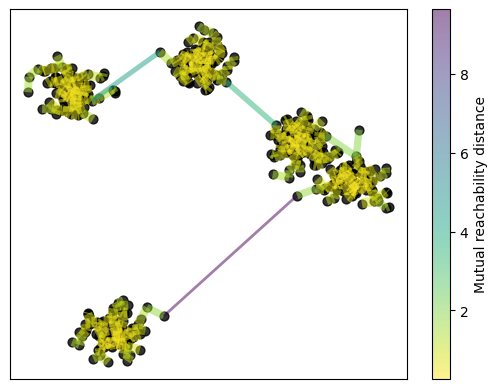

In [7]:
hdbscan_instance.minimum_spanning_tree_.plot()

<Axes: ylabel='distance'>

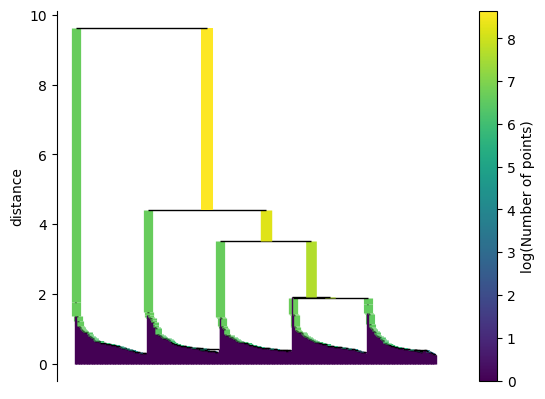

In [4]:
hdbscan_instance.single_linkage_tree_.plot()

<Axes: ylabel='$\\lambda$ value'>

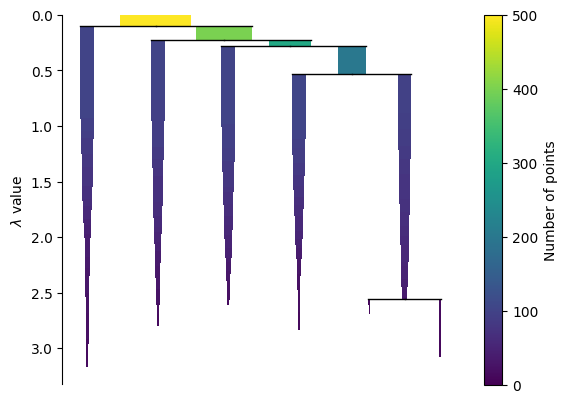

In [3]:
hdbscan_instance.condensed_tree_.plot()